<a href="https://colab.research.google.com/github/jasonh14/bert_roberta_financial_sentiment_analysis/blob/main/aol_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 784.9 kB/s eta 0:00:00


In [3]:
!pip install transformers

In [4]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import demoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<ipython-input-4-fdfd43664146>:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [5]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

In [7]:
data = pd.read_csv("data.csv")

In [8]:
data.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [10]:
data.drop_duplicates(subset='Sentence',inplace=True)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5322 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5322 non-null   object
 1   Sentiment  5322 non-null   object
dtypes: object(2)
memory usage: 124.7+ KB


In [12]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def strip_emoji(text):
  return demoji.replace(text, '') #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2


#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [13]:
texts_new = []
for t in data.Sentence:
  texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))

In [14]:
texts_new

['the geosolutions technology will leverage benefon s gps solutions by providing location based search technology a communities platform location relevant multimedia content and a new and powerful commercial model',
 'esi on lows down 150 to 250 bk a real possibility',
 'for the last quarter of 2010 componenta s net sales doubled to eur131m from eur76m for the same period a year earlier while it moved to a zero pretax profit from a pretax loss of eur7m',
 'according to the finnishrussian chamber of commerce all the major construction companies of finland are operating in russia',
 'the swedish buyout firm has sold its remaining 224 percent stake almost eighteen months after taking the company public in finland',
 'spy wouldnt be surprised to see a green close',
 'shells 70 billion bg deal meets shareholder skepticism',
 'ssh communications security corp stock exchange release october 14 2008 at 245 pm the company updates its full year outlook and estimates its results to remain at loss

In [15]:
data["Sentence_clean"] = texts_new

In [16]:
data.head()

,Sentence,Sentiment,Sentence_clean
0,The GeoSolutions technology will leverage Bene...,positive,the geosolutions technology will leverage bene...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi on lows down 150 to 250 bk a real possibility
2,"For the last quarter of 2010 , Componenta 's n...",positive,for the last quarter of 2010 componenta s net ...
3,According to the Finnish-Russian Chamber of Co...,neutral,according to the finnishrussian chamber of com...
4,The Swedish buyout firm has sold its remaining...,neutral,the swedish buyout firm has sold its remaining...


In [17]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
token_lens = []

for txt in data['Sentence_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [19]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 110


In [20]:
for txt in data['Sentence_clean'].values:
  print(txt)

Streaming output truncated to the last 5000 lines.
dgi technical alerts gilligans island buy setup stochastic buy signal lizard bullish hammer candlestick wid
the record date for dividend distribution is march 14 2008
ih in a move to enhance growth
the ebrd is using its own funds to provide a 216 million a loan while the b portion of 10 million euros has been syndicated to two finnish commercial banks nordea bank finland plc 77 million euros and pohjola bank plc 23 million euros
stockholm 3 march 2011 about cybercom the cybercom group is a hightech consultancy that offers global sourcing for endtoend solutions
he said he has been losing five families a month to the economy as many make alternative arrangements to save money
milan afx the italian shipping group grimaldi has increased its stake in the finnish company finnlines to 354 pct from the 305 pct held in june according to news agency ansa
commenting on the deal shane lennon svp of marketing product development at gypsii said
exte

In [21]:
token_lens = []

for i,txt in enumerate(data['Sentence_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 3573, TEXT: supported nokia phones include n96 n958gb n95 n93n931 n92 n85 n82 n81 n80 n79 n78 n77 n76 n75 n73 n72 n71 e90 e71 e70 e66 e65 e62 e61e61i e60 e51 e50 touch xpress 5800 6220 classic 6210 navigator 6120 classic 6110 navigator 5700 5500 5320xm


In [22]:
data['token_lens'] = token_lens

In [23]:
data = data.sort_values(by='token_lens', ascending=False)
data.head(20)

,Sentence,Sentiment,Sentence_clean,token_lens
3800,"Supported Nokia phones include : N96 , N95-8GB...",neutral,supported nokia phones include n96 n958gb n95 ...,110
130,Alma Media Corporation Press Release 15 March ...,neutral,alma media corporation press release 15 march ...,76
2251,3 January 2011 - Scandinavian lenders Sampo Ba...,neutral,3 january 2011 scandinavian lenders sampo bank...,75
3611,"According to its notice , Skandinaviska Enskil...",neutral,according to its notice skandinaviska enskilda...,71
2379,Body ES Vostok also owns stakes in power sales...,neutral,body es vostok also owns stakes in power sales...,70
5457,narrows to EUR2 .8 m 9-mo '09 29 October 2009 ...,positive,narrows to eur2 8 m 9mo 09 29 october 2009 fin...,70
4262,"MANAVIGATOR-September 7 , 2010-Kemira unveils ...",positive,manavigatorseptember 7 2010kemira unveils indi...,69
5796,"H1 '08 H1 '07 Q2 '08 Q2 '07 in mln euro , unle...",neutral,h1 08 h1 07 q2 08 q2 07 in mln euro unless oth...,68
2652,PGE Belchatow runs the 4.44 GW Belchatow coal-...,neutral,pge belchatow runs the 444 gw belchatow coalfi...,67
854,1 p.m. Central office of Nordea Bank 19 3-ya u...,neutral,1 pm central office of nordea bank 19 3ya ulit...,65


In [24]:
data = data.sample(frac=1).reset_index(drop=True)

In [25]:
data

,Sentence,Sentiment,Sentence_clean,token_lens
0,"Net interest income was EUR 152.2 mn , up from...",positive,net interest income was eur 1522 mn up from eu...,20
1,@technik I still have a smaller $GILD pos. Bei...,positive,i still have a smaller gild pos being very ten...,28
2,The final price will be specified by 14 May 20...,neutral,the final price will be specified by 14 may 20...,16
3,Around 250 of these reductions will be impleme...,neutral,around 250 of these reductions will be impleme...,13
4,"However , the production is almost entirely ve...",neutral,however the production is almost entirely very...,17
...,...,...,...,...
5317,No pricing details were disclosed .,neutral,no pricing details were disclosed,7
5318,"Finnair 's Tallinn-based subsidiary , Aero AS ...",negative,finnair s tallinnbased subsidiary aero as carr...,32
5319,"MANAVIGATOR-September 7 , 2010-Kemira unveils ...",positive,manavigatorseptember 7 2010kemira unveils indi...,69
5320,Continuing operations turned an operating loss...,positive,continuing operations turned an operating loss...,27


In [26]:
data['Sentiment'].value_counts()

neutral     2878
positive    1852
negative     592
Name: Sentiment, dtype: int64

In [27]:
# Encode sentiment column Negative = 0, Neutral = 1, Positive = 2
data['Sentiment'] = data['Sentiment'].map({'negative':0,'neutral':1,'positive':2})

In [28]:
data['Sentiment'].value_counts()

1    2878
2    1852
0     592
Name: Sentiment, dtype: int64

In [29]:
data['Sentiment']

0       2
1       2
2       1
3       1
4       1
       ..
5317    1
5318    0
5319    2
5320    2
5321    1
Name: Sentiment, Length: 5322, dtype: int64

In [30]:
# ros = RandomOverSampler()
# train_x, train_y = ros.fit_resample(np.array(data['Sentence_clean']).reshape(-1, 1), np.array(data['Sentiment']).reshape(-1, 1));
# train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['Sentence_clean', 'Sentiment']);

In [31]:
train_os = data

In [32]:
train_os['Sentiment'].value_counts()

1    2878
2    1852
0     592
Name: Sentiment, dtype: int64

In [33]:
train_df, test_df = train_test_split(train_os, test_size=0.3, shuffle=True, random_state=1)

In [34]:
train_df['Sentiment'].value_counts()

1    2036
2    1292
0     397
Name: Sentiment, dtype: int64

In [35]:
test_df['Sentiment'].value_counts()

1    842
2    560
0    195
Name: Sentiment, dtype: int64

In [36]:
# First, split 'train_os' into training and testing sets, stratifying by 'Sentiment'
X_train, X_test, y_train, y_test = train_test_split(train_os['Sentence_clean'].values, train_os['Sentiment'].values, test_size=0.3, stratify=train_os['Sentiment'], random_state=seed)

# Then, split the training set into training and validation sets, still stratifying by 'Sentiment'
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed)


In [37]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()
y_train_le

array([1, 2, 2, ..., 0, 1, 1])

In [38]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()
y_train

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [39]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 3352
VALIDATION DATA: 373
TESTING DATA: 1597


In [40]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [41]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [42]:
nb_clf = MultinomialNB()

In [43]:
nb_clf.fit(X_train_tf, y_train_le)

MultinomialNB()

In [44]:
nb_pred = nb_clf.predict(X_test_tf)

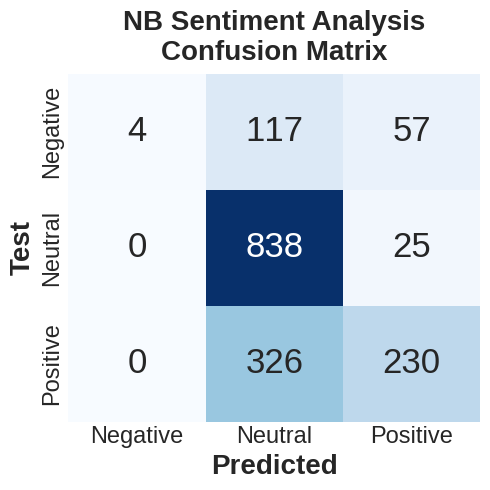

In [45]:
conf_matrix(y_test_le, nb_pred,'NB Sentiment Analysis\nConfusion Matrix')

In [46]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       1.00      0.02      0.04       178
     Neutral       0.65      0.97      0.78       863
    Positive       0.74      0.41      0.53       556

    accuracy                           0.67      1597
   macro avg       0.80      0.47      0.45      1597
weighted avg       0.72      0.67      0.61      1597



In [47]:
print('Accuracy for Naive Bayes: ', accuracy_score(y_test_le, nb_pred))

Accuracy for Naive Bayes:  0.6712586098935505


BERT

In [48]:
MAX_LEN=128

In [49]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [50]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [51]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [52]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Assuming y_train contains the labels in a categorical format

# Calculate class weights
train_classes = data['Sentiment']
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))

class_weights

{0: 2.9966216216216215, 1: 0.6164002779708131, 2: 0.9578833693304536}

In [53]:
def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)


    return model

In [54]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                             

In [55]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=32, class_weight=class_weights)

Epoch 1/4
105/105 [==============================] - 123s 820ms/step - loss: 0.9354 - categorical_accuracy: 0.5558 - val_loss: 0.7011 - val_categorical_accuracy: 0.7131
Epoch 2/4
105/105 [==============================] - 85s 814ms/step - loss: 0.5313 - categorical_accuracy: 0.7613 - val_loss: 0.5265 - val_categorical_accuracy: 0.8016
Epoch 3/4
105/105 [==============================] - 84s 796ms/step - loss: 0.3347 - categorical_accuracy: 0.8413 - val_loss: 0.4748 - val_categorical_accuracy: 0.8097
Epoch 4/4
105/105 [==============================] - 86s 815ms/step - loss: 0.2379 - categorical_accuracy: 0.8819 - val_loss: 0.4441 - val_categorical_accuracy: 0.8257


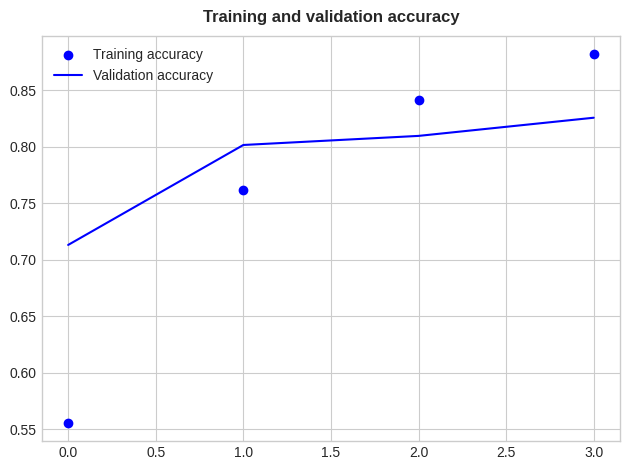

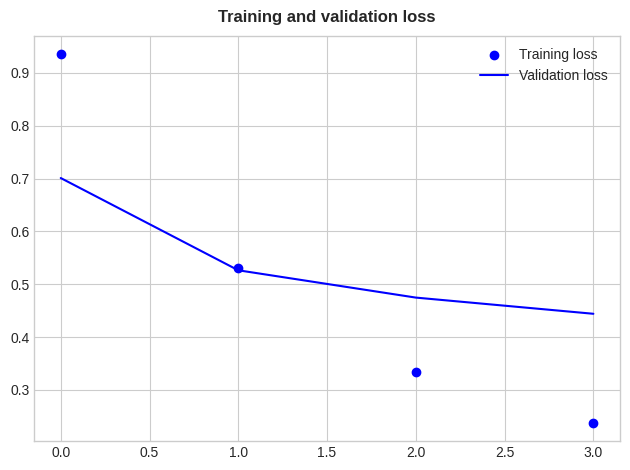

In [56]:
# Accessing training and validation metrics
accuracy = history_bert.history['categorical_accuracy']
val_accuracy = history_bert.history['val_categorical_accuracy']

loss = history_bert.history['loss']
val_loss = history_bert.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [57]:
result_bert = model.predict([test_input_ids,test_attention_masks])


50/50 [==============================] - 17s 270ms/step


In [58]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

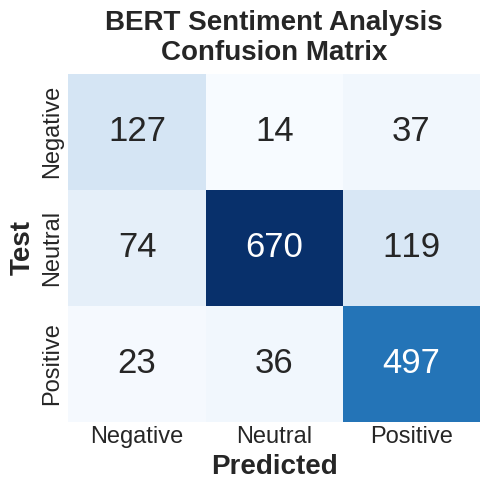

In [59]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT Sentiment Analysis\nConfusion Matrix')


In [60]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.57      0.71      0.63       178
     Neutral       0.93      0.78      0.85       863
    Positive       0.76      0.89      0.82       556

   micro avg       0.81      0.81      0.81      1597
   macro avg       0.75      0.79      0.77      1597
weighted avg       0.83      0.81      0.81      1597
 samples avg       0.81      0.81      0.81      1597



In [61]:
print('Accuracy for Bert: ', accuracy_score(y_test, y_pred_bert))

Accuracy for Bert:  0.8102692548528491


RoBERTa

In [62]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [63]:
token_lens = []

for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

78

In [64]:
MAX_LEN=128

In [65]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [66]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

In [67]:
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(3, activation=tf.nn.softmax)(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=accuracy)
    return model

In [68]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.dense.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

In [69]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_3[0][0]',             
 aModel)                     ngAndCrossAttentions(last_   32         'input_4[0][0]']             
                             hidden_state=(None, 128, 7                                           
                             68),                                                           

In [70]:
history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid), epochs=4, batch_size=30, class_weight=class_weights)


Epoch 1/4
112/112 [==============================] - 107s 798ms/step - loss: 0.8073 - categorical_accuracy: 0.5955 - val_loss: 0.4980 - val_categorical_accuracy: 0.7855
Epoch 2/4
112/112 [==============================] - 84s 746ms/step - loss: 0.4090 - categorical_accuracy: 0.8201 - val_loss: 0.6147 - val_categorical_accuracy: 0.7694
Epoch 3/4
112/112 [==============================] - 86s 764ms/step - loss: 0.2948 - categorical_accuracy: 0.8658 - val_loss: 0.5069 - val_categorical_accuracy: 0.7936
Epoch 4/4
112/112 [==============================] - 86s 764ms/step - loss: 0.2362 - categorical_accuracy: 0.8866 - val_loss: 0.4619 - val_categorical_accuracy: 0.8311


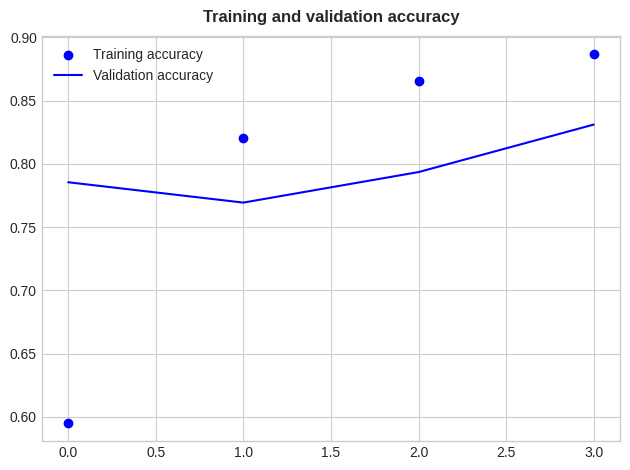

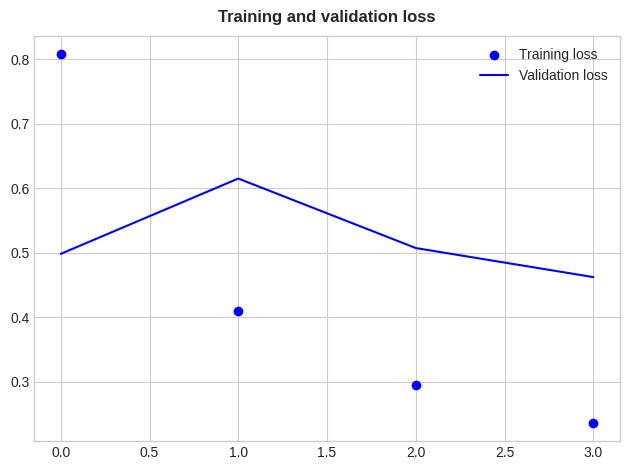

In [71]:
# Accessing training and validation metrics
accuracy = history_2.history['categorical_accuracy']
val_accuracy = history_2.history['val_categorical_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [72]:
result_roberta = model.predict([test_input_ids,test_attention_masks])


50/50 [==============================] - 16s 258ms/step


In [73]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

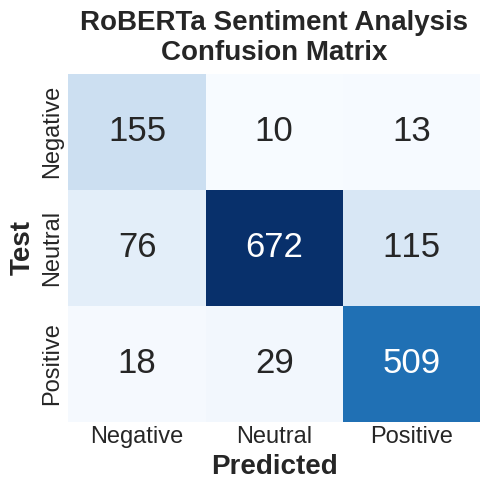

In [74]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [75]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.62      0.87      0.73       178
     Neutral       0.95      0.78      0.85       863
    Positive       0.80      0.92      0.85       556

   micro avg       0.84      0.84      0.84      1597
   macro avg       0.79      0.85      0.81      1597
weighted avg       0.86      0.84      0.84      1597
 samples avg       0.84      0.84      0.84      1597



In [76]:
print('Accuracy for RoBerta: ', accuracy_score(y_test, y_pred_roberta))

Accuracy for RoBerta:  0.8365685660613651


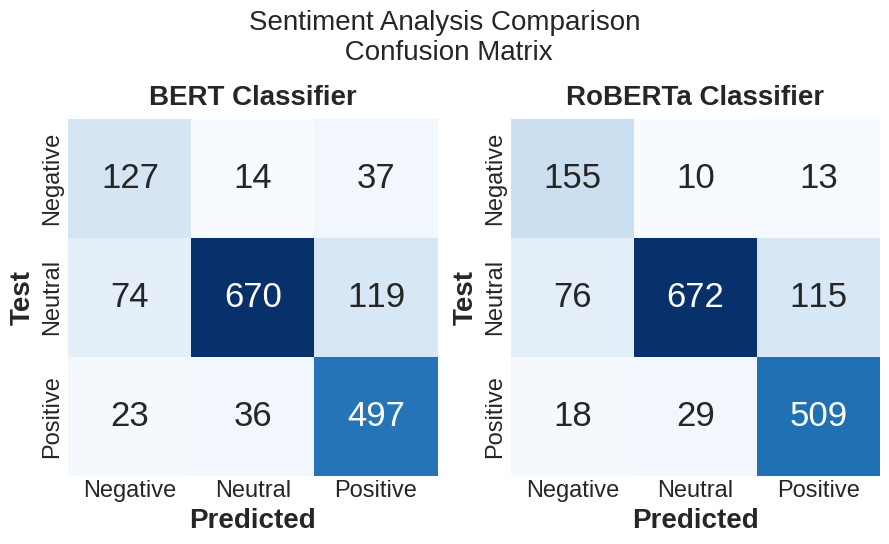

In [77]:
fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Neutral', 'Positive']
plt.suptitle('Sentiment Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

ax[0].set_title('BERT Classifier', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17);
ax[0].set_xticklabels(labels, fontsize=17);
ax[0].set_ylabel('Test', fontsize=20)
ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),y_pred_roberta.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('RoBERTa Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17);
ax[1].set_xticklabels(labels, fontsize=17);
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)


plt.show()

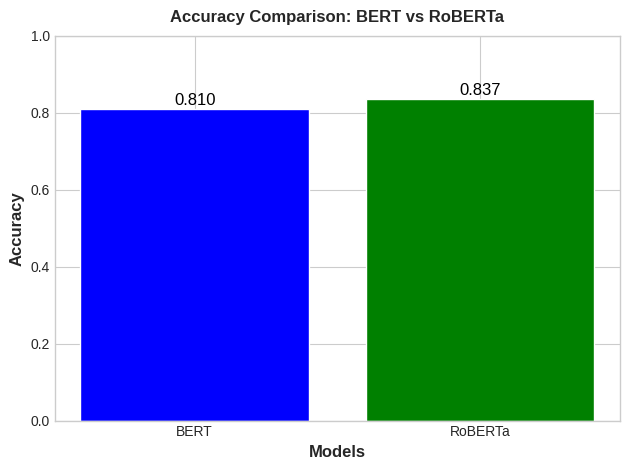

In [78]:
accuracy_bert = accuracy_score(y_test, y_pred_bert)
accuracy_roberta = accuracy_score(y_test, y_pred_roberta)

# Plotting the accuracies
models = ['BERT', 'RoBERTa']
accuracies = [accuracy_bert, accuracy_roberta]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: BERT vs RoBERTa')
plt.ylim(0, 1)  # Set the y-axis limit to represent accuracy (0 to 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', color='black', fontsize=12)

plt.show()